<a href="https://colab.research.google.com/github/Mihirirj/Audio_PRE-FE/blob/main/LSTM%2BCNN(FYP).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!apt-get update -qq && apt-get install -y libsndfile1 -qq
!pip install -q -U google-generativeai librosa tensorflow scikit-learn pandas seaborn matplotlib



import pandas as pd
import numpy as np
import os
import sys
import pickle
from tqdm.notebook import tqdm
import random

# Audio Processing
import librosa
import librosa.display

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Scikit-learn for Preprocessing and Metrics
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# Keras / TensorFlow for Model Building
import tensorflow as tf
from tensorflow.keras.models import Sequential, model_from_json
from tensorflow.keras.layers import (
    Conv1D, MaxPooling1D, BatchNormalization, Dropout, Flatten, Dense,
    LSTM
)
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau


import google.generativeai as genai
from IPython.display import display, HTML, Markdown, clear_output
from google.colab import userdata, drive
from google.colab.output import eval_js
from base64 import b64decode
import io


import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

print(" Libraries imported and system updated successfully.")

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
 Libraries imported and system updated successfully.


In [6]:
try:
    drive.mount('/content/drive')

    CREMA_D_PATH = "/content/drive/MyDrive/AudioWAV/"

    if not os.path.exists(CREMA_D_PATH):
        print(f" ERROR: The path '{CREMA_D_PATH}' does not exist.")
        print("Please make sure you have uploaded the 'AudioWAV' folder to your Google Drive and updated the CREMA_D_PATH variable.")
    else:
        print("  Google Drive mounted and dataset path confirmed.")
except Exception as e:
    print(f" ERROR mounting drive: {e}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
  Google Drive mounted and dataset path confirmed.


In [7]:
crema_directory_list = os.listdir(CREMA_D_PATH)

file_emotion = []
file_path = []


emotion_map = {
    'SAD': 'sad', 'ANG': 'angry', 'DIS': 'disgust',
    'FEA': 'fear', 'HAP': 'happy', 'NEU': 'neutral'
}

for file in tqdm(crema_directory_list, desc="Processing filenames"):
    file_path.append(os.path.join(CREMA_D_PATH, file))
    part = file.split('_')
    emotion_code = part[2]
    file_emotion.append(emotion_map.get(emotion_code, 'Unknown'))


emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])
path_df = pd.DataFrame(file_path, columns=['Path'])
data_path = pd.concat([emotion_df, path_df], axis=1)


data_path = data_path[data_path['Emotions'] != 'Unknown']

print("\n CREMA-D DataFrame created successfully.")
print("\nEmotion Counts in the Dataset:")
print(data_path['Emotions'].value_counts())

Processing filenames:   0%|          | 0/7442 [00:00<?, ?it/s]


 CREMA-D DataFrame created successfully.

Emotion Counts in the Dataset:
Emotions
fear       1271
disgust    1271
sad        1271
happy      1271
angry      1271
neutral    1087
Name: count, dtype: int64


/tmp/ipython-input-3266510839.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=data_path.Emotions, palette="viridis", order=data_path['Emotions'].value_counts().index)


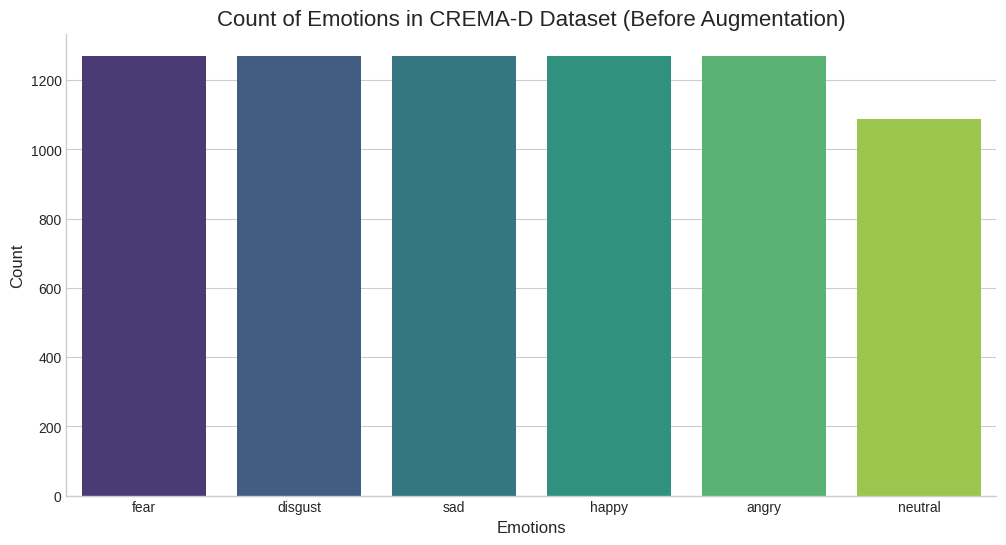

 Exploratory Data Analysis complete.


In [9]:
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(12, 6))
plt.title('Count of Emotions in CREMA-D Dataset (Before Augmentation)', size=16)
sns.countplot(x=data_path.Emotions, palette="viridis", order=data_path['Emotions'].value_counts().index)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()
print(" Exploratory Data Analysis complete.")

In [10]:
def noise(data, noise_factor=0.035):

    noise_amp = noise_factor * np.random.uniform() * np.amax(data)
    data = data + noise_amp * np.random.normal(size=data.shape[0])
    return data


def extract_features_sequential(data, sr=22050, n_mfcc=40):

    mfccs = librosa.feature.mfcc(y=data, sr=sr, n_mfcc=n_mfcc)
    return mfccs.T


def get_features_with_noise_augmentation(path):

    data, sr = librosa.load(path, duration=2.5, offset=0.6)

    #  Original Features
    original_features = extract_features_sequential(data, sr)

    #  Noise-Augmented Features
    noise_data = noise(data)
    noise_features = extract_features_sequential(noise_data, sr)

    return [original_features, noise_features]

print("Feature extraction and focused noise augmentation functions defined.")

Feature extraction and focused noise augmentation functions defined.


In [11]:
X_seq, Y_seq = [], []

for path, emotion in tqdm(zip(data_path.Path, data_path.Emotions), total=len(data_path), desc="Augmenting (Noise) and Extracting Features"):
    try:

        feature_list = get_features_with_noise_augmentation(path)
        for features in feature_list:
            X_seq.append(features)

            Y_seq.append(emotion)
    except Exception as e:
        print(f"Error processing {path}: {e}")


max_len = max([len(x) for x in X_seq])
print(f"\nMaximum sequence length found: {max_len}")

X_padded = pad_sequences(X_seq, maxlen=max_len, padding='post', dtype='float32')

np.save('/content/drive/MyDrive/X_padded_features_noise_only.npy', X_padded)
np.save('/content/drive/MyDrive/Y_labels_noise_only.npy', np.array(Y_seq))
with open('/content/drive/MyDrive/max_len_noise_only.txt', 'w') as f:
    f.write(str(max_len))

print(f"\nDataset size after noise augmentation: {len(X_padded)} samples (doubled).")
print("\n Noise-augmented sequential features saved to Google Drive.")

Augmenting (Noise) and Extracting Features:   0%|          | 0/7442 [00:00<?, ?it/s]


Maximum sequence length found: 108

Dataset size after noise augmentation: 14884 samples (doubled).

 Noise-augmented sequential features saved to Google Drive.


In [12]:
X = np.load('/content/drive/MyDrive/X_padded_features_noise_only.npy')
Y = np.load('/content/drive/MyDrive/Y_labels_noise_only.npy')


encoder = OneHotEncoder(sparse_output=False)
Y = encoder.fit_transform(np.array(Y).reshape(-1, 1))


x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=42, test_size=0.2, shuffle=True)


scaler = StandardScaler()
x_train = scaler.fit_transform(x_train.reshape(-1, x_train.shape[-1])).reshape(x_train.shape)
x_test = scaler.transform(x_test.reshape(-1, x_test.shape[-1])).reshape(x_test.shape)

print(f"Data shapes: \nx_train: {x_train.shape}\ny_train: {y_train.shape}\nx_test: {x_test.shape}\ny_test: {y_test.shape}")
print("\n Data loaded, encoded, split, and scaled successfully.")

Data shapes: 
x_train: (11907, 108, 40)
y_train: (11907, 6)
x_test: (2977, 108, 40)
y_test: (2977, 6)

 Data loaded, encoded, split, and scaled successfully.


In [13]:
input_shape = (x_train.shape[1], x_train.shape[2])
model = Sequential([
    Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=input_shape),
    BatchNormalization(), MaxPooling1D(pool_size=5, strides=2, padding='same'),
    Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'),
    BatchNormalization(), MaxPooling1D(pool_size=5, strides=2, padding='same'), Dropout(0.3),
    Conv1D(64, kernel_size=3, strides=1, padding='same', activation='relu'),
    BatchNormalization(), MaxPooling1D(pool_size=5, strides=2, padding='same'),
    LSTM(64), Dropout(0.3),
    Dense(64, activation='relu'), BatchNormalization(),
    Dense(y_train.shape[1], activation='softmax')
])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()
print("\n Hybrid CNN-LSTM model built successfully.")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 108, 256)       │        51,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 108, 256)       │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 54, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 54, 128)        │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 54, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 27, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 27, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 27, 64)         │        24,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 27, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 14, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 279,686 (1.07 MB)

 Trainable params: 278,662 (1.06 MB)

 Non-trainable params: 1,024 (4.00 KB)


 Hybrid CNN-LSTM model built successfully.


In [14]:
early_stop = EarlyStopping(monitor='val_accuracy', mode='max', patience=15, restore_best_weights=True)
lr_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=5, verbose=1, factor=0.5, min_lr=0.00001)

model_checkpoint = ModelCheckpoint('best_model_noise_aug.keras', monitor='val_accuracy', save_best_only=True)

print("\nStarting model training on noise-augmented data...")
history = model.fit(
    x_train, y_train,
    epochs=100, batch_size=64, validation_data=(x_test, y_test),
    callbacks=[early_stop, lr_reduction, model_checkpoint]
)
print("\n Model training complete.")


Starting model training on noise-augmented data...
Epoch 1/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 50s 228ms/step - accuracy: 0.2651 - loss: 1.8641 - val_accuracy: 0.4175 - val_loss: 1.4763 - learning_rate: 0.0010
Epoch 2/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 82s 229ms/step - accuracy: 0.4266 - loss: 1.4325 - val_accuracy: 0.4380 - val_loss: 1.3699 - learning_rate: 0.0010
Epoch 3/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 41s 219ms/step - accuracy: 0.4828 - loss: 1.3112 - val_accuracy: 0.4988 - val_loss: 1.2816 - learning_rate: 0.0010
Epoch 4/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 40s 215ms/step - accuracy: 0.5289 - loss: 1.2177 - val_accuracy: 0.5250 - val_loss: 1.2361 - learning_rate: 0.0010
Epoch 5/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 45s 237ms/step - accuracy: 0.5626 - loss: 1.1550 - val_accuracy: 0.5546 - val_loss: 1.1516 - learning_rate: 0.0010
Epoch 6/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 42s 227ms/step - accuracy: 0.6000 - loss: 1.0770 - val_accuracy: 0.5932 - val_loss: 1.0848 - learning_rate: 0.0010
Epoch 7/100


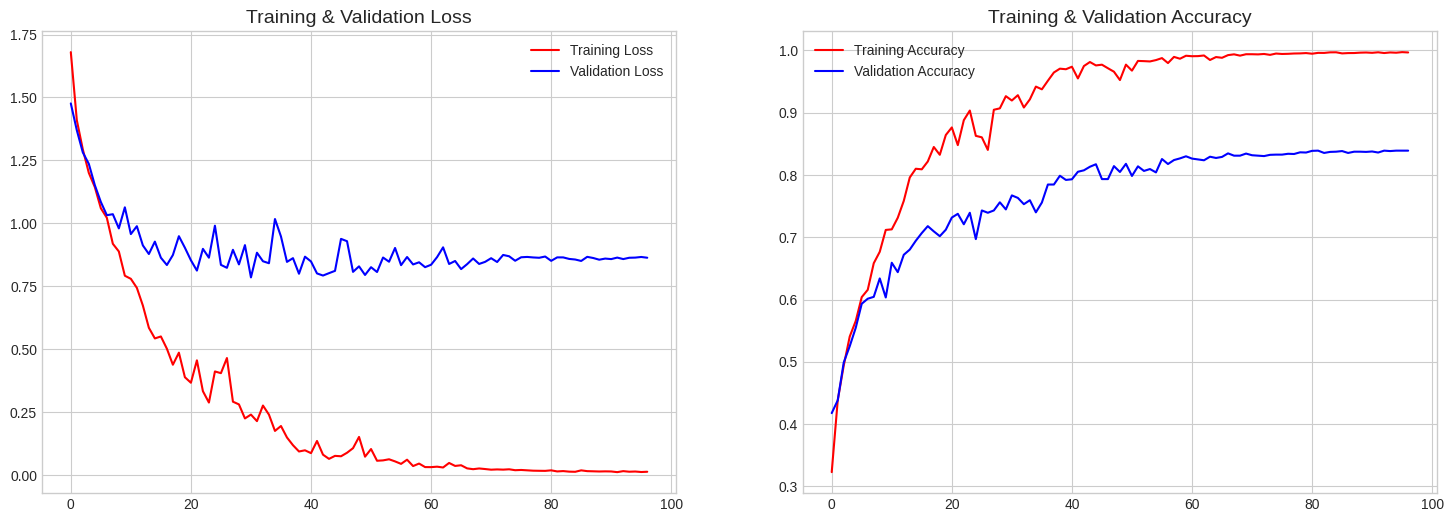


Final Model Evaluation on Test Data 
Test Accuracy: 83.91%
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step

 Classification Report 
              precision    recall  f1-score   support

       angry       0.93      0.87      0.90       529
     disgust       0.85      0.84      0.85       493
        fear       0.85      0.76      0.80       546
       happy       0.85      0.84      0.84       500
     neutral       0.83      0.87      0.85       415
         sad       0.73      0.86      0.79       494

    accuracy                           0.84      2977
   macro avg       0.84      0.84      0.84      2977
weighted avg       0.84      0.84      0.84      2977


 Confusion Matrix 


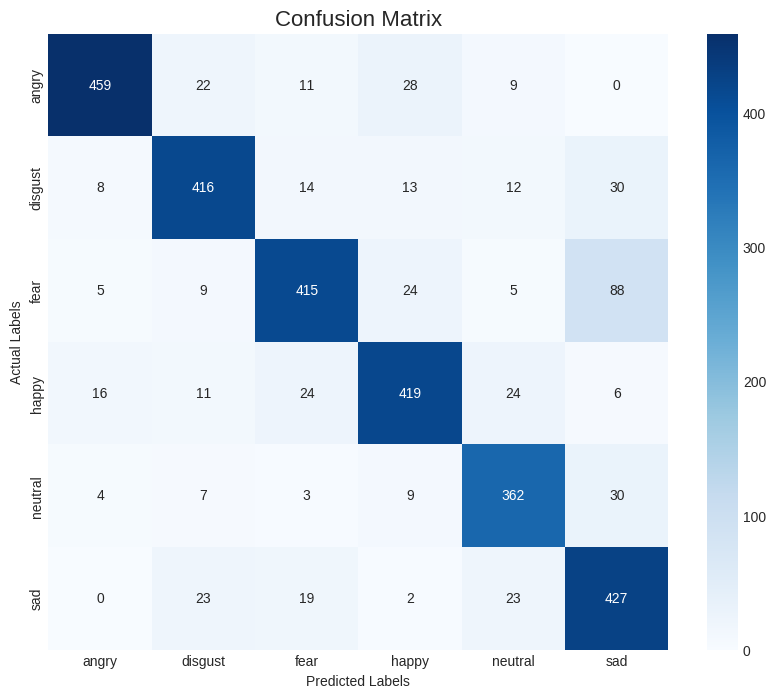


 Model evaluation complete.


In [15]:
fig, ax = plt.subplots(1, 2, figsize=(18, 6))
ax[0].plot(history.history['loss'], 'r-', label='Training Loss'); ax[0].plot(history.history['val_loss'], 'b-', label='Validation Loss')
ax[0].set_title('Training & Validation Loss', fontsize=14); ax[0].legend()
ax[1].plot(history.history['accuracy'], 'r-', label='Training Accuracy'); ax[1].plot(history.history['val_accuracy'], 'b-', label='Validation Accuracy')
ax[1].set_title('Training & Validation Accuracy', fontsize=14); ax[1].legend()
plt.show()


print("\nFinal Model Evaluation on Test Data ")
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy*100:.2f}%")


y_pred_probs = model.predict(x_test)
y_pred_labels = encoder.inverse_transform(y_pred_probs)
y_test_labels = encoder.inverse_transform(y_test)
emotion_labels = encoder.categories_[0]

print("\n Classification Report ")
print(classification_report(y_test_labels, y_pred_labels, target_names=emotion_labels))

print("\n Confusion Matrix ")
cm = confusion_matrix(y_test_labels, y_pred_labels, labels=emotion_labels)
plt.figure(figsize=(10, 8)); sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=emotion_labels, yticklabels=emotion_labels)
plt.title('Confusion Matrix', fontsize=16); plt.ylabel('Actual Labels'); plt.xlabel('Predicted Labels'); plt.show()

def get_valence(emotion):
    return 'Positive' if emotion.lower() == 'happy' else 'Negative' if emotion.lower() in ['sad', 'angry', 'fear', 'disgust'] else 'Neutral'

print("\n Model evaluation complete.")

In [16]:
model_json = model.to_json()
with open("model_noise_aug.json", "w") as json_file:
    json_file.write(model_json)
with open('scaler_noise_aug.pkl', 'wb') as f:
    pickle.dump(scaler, f)
with open('encoder_noise_aug.pkl', 'wb') as f:
    pickle.dump(encoder, f)

print("Model architecture saved to: model_noise_aug.json")
print("Best model weights saved to: best_model_noise_aug.keras")
print("Scaler saved to: scaler_noise_aug.pkl")
print("Encoder saved to: encoder_noise_aug.pkl")
print("\n All necessary artifacts for the noise-augmented model saved successfully.")

Model architecture saved to: model_noise_aug.json
Best model weights saved to: best_model_noise_aug.keras
Scaler saved to: scaler_noise_aug.pkl
Encoder saved to: encoder_noise_aug.pkl

 All necessary artifacts for the noise-augmented model saved successfully.


In [17]:
def predict_emotion_from_file(audio_path, model_json_path, weights_path, scaler_path, encoder_path, max_len_path):
    try:
        with open(model_json_path, 'r') as json_file:
            loaded_model = model_from_json(json_file.read())
        loaded_model.load_weights(weights_path)
        with open(scaler_path, 'rb') as f: scaler = pickle.load(f)
        with open(encoder_path, 'rb') as f: encoder = pickle.load(f)
        with open(max_len_path, 'r') as f: max_len = int(f.read())

        data, sr = librosa.load(audio_path, duration=2.5, offset=0.6)
        features = extract_features_sequential(data, sr, n_mfcc=40)
        padded = pad_sequences([features], maxlen=max_len, padding='post', dtype='float32')
        scaled = scaler.transform(padded.reshape(-1, padded.shape[-1])).reshape(padded.shape)
        prediction = loaded_model.predict(scaled, verbose=0)
        label = encoder.inverse_transform(prediction)[0][0]
        valence = get_valence(label)
        return label, valence
    except Exception as e: return f"Error: {e}", None

try:
    test_file = data_path.Path.sample(1).iloc[0]
    p_label, p_valence = predict_emotion_from_file(
        test_file, 'model_noise_aug.json', 'best_model_noise_aug.keras',
        'scaler_noise_aug.pkl', 'encoder_noise_aug.pkl', '/content/drive/MyDrive/max_len_noise_only.txt'
    )
    print("\n--- Single File Prediction Test ---")
    print(f"File: ...{test_file[-20:]}\nPredicted Emotion: {p_label.upper()}\nPredicted Valence: {p_valence.upper()}")
    print("\ Single file prediction demo complete.")
except Exception as e: print(f"Could not run prediction example: {e}")


--- Single File Prediction Test ---
File: .../1088_IEO_HAP_MD.wav
Predicted Emotion: HAPPY
Predicted Valence: POSITIVE
\ Single file prediction demo complete.


In [21]:

from IPython.display import display, HTML, clear_output
from google.colab.output import eval_js
from base64 import b64decode

def get_audio_test():
    """A simplified, standalone function to test the microphone in Colab."""
    JS_CODE = """
    return new Promise(async (resolve) => {
        const div = document.createElement('div');
        const button = document.createElement('button');
        button.textContent = 'Start Recording Test';
        div.appendChild(button);
        document.body.appendChild(div);

        button.onclick = async () => {
            try {
                // Request microphone access
                const stream = await navigator.mediaDevices.getUserMedia({ audio: true });
                const recorder = new MediaRecorder(stream);
                let recordedChunks = [];

                recorder.ondataavailable = e => {
                    if (e.data.size > 0) recordedChunks.push(e.data);
                };

                recorder.onstop = () => {
                    const blob = new Blob(recordedChunks, { type: 'audio/webm' });
                    const reader = new FileReader();
                    reader.onloadend = () => {
                        div.remove();
                        resolve(reader.result);
                    };
                    reader.readAsDataURL(blob);
                };

                // Start recording and set timeout
                recorder.start();
                button.textContent = 'Recording...';
                button.disabled = true;

                setTimeout(() => {
                    if (recorder.state === 'recording') {
                        recorder.stop();
                        stream.getTracks().forEach(track => track.stop());
                    }
                }, 5000);

            } catch (err) {
                console.error(err);
                // Display the error in the Colab output
                div.innerHTML = `<strong>Error:</strong> ${err.message}<br/>Please check browser permissions (the lock icon in the address bar) and try again.`;
                resolve(null); // Resolve with null to signal failure
            }
        };
    });
    """
    try:
        print("Displaying recording button...")
        data = eval_js(JS_CODE)
        clear_output(wait=True)

        if data:
            print("Recording successful! Saving to 'test_audio.wav'.")
            binary = b64decode(data.split(',')[1])
            with open("test_audio.wav", 'wb') as f:
                f.write(binary)
            return "test_audio.wav"
        else:
            print("Recording failed or was cancelled. Please check the error message above.")
            return None
    except Exception as e:
        clear_output(wait=True)
        print(f"A Python-level error occurred: {e}")
        return None


get_audio_test()

A Python-level error occurred: SyntaxError: Illegal return statement


In [22]:
model.save('my_model.h5')


In [23]:
from google.colab import files
files.download('my_model.h5')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [24]:
import pickle


with open('history.pkl', 'wb') as f:
    pickle.dump(history.history, f)


from google.colab import files
files.download('history.pkl')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>